# % DSP, Assignment 3, Anish Das $<$ ad945$>$ November 2020

## Part (a)

In [1]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as image
from scipy.fft import fft2, ifft2
from scipy.io.wavfile import read, write

In [2]:
# loading both the blurred image & the point-spread function
base_image = np.array(image.imread('stars-blurred.png'))
base_imageX, base_imageY = base_image.shape
psf_image = np.array(image.imread('stars-psf.png'))
psf_imageX, psf_imageY = psf_image.shape

In [3]:
# Applying window

#creating the windows along X and Y.
windowX = signal.windows.hann(base_imageX)
windowY = signal.windows.hann(base_imageY)

# building the final window using outer product and power.
window = np.outer(windowX, windowY)
window = np.power(window, 1/3.5)

base_windowed = np.multiply(base_image, window)

<img src="window_power.png">
<center>
Using a hann window raised to the power (1/3.5) so that we can capture more of the star. 
<center>
Not using the window introduces vertical and horizontal white lines and doesn't produce a clear image.


In [4]:
# Padding the images to be 512 by 512
base_padded = np.zeros((512, 512))
base_padded[:base_imageX, :base_imageY] = base_windowed
psf_padded = np.zeros((512, 512))
psf_padded[:psf_imageX, :psf_imageY] = psf_image

In [5]:
# Getting the 2D fourier transforms of the padded image and psf
base_fft = np.fft.fft2(base_padded)
psf_fft = fft2(psf_padded)

In [6]:
threshold = 5

# anything above the threshold remains the same while 
# anything below the threshold goes to threshold
adjusted_psf_fft = (np.abs(psf_fft) > threshold) * psf_fft
adjusted_psf_fft += (np.abs(psf_fft) <= threshold) * threshold

[]

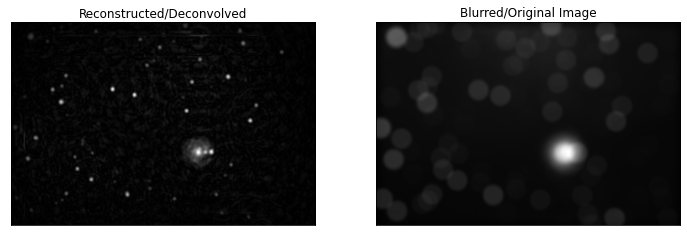

In [7]:
# deconvolving in the frequency domain (diving by the adjusted psf_fft)
image_fft = base_fft / adjusted_psf_fft

# reconstructing the image using inverse FFT
image_reconstructed = ifft2(image_fft)

# Realigning the reconstructed image.
image_reconstructed = np.roll(a=image_reconstructed, shift=15, axis=0)
image_reconstructed = np.roll(a=image_reconstructed, shift=15, axis=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.abs(image_reconstructed[:base_imageX, :base_imageY]), cmap='gray')
axs[1].imshow(base_image, cmap='gray')
axs[0].set_title('Reconstructed/Deconvolved')
axs[1].set_title('Blurred/Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

Comparing it to the original image in the slides, we can see that some of the stars in the edges have dissapeared or have been dimmed 

## Part (b.i)

In [8]:
# loading in the floats and then converting to a complex signal.
floats_b = np.fromfile(file='iq-fm-96M-240k.dat', dtype=np.float32)
signal_b_i = floats_b[::2] + 1j*floats_b[1::2]
print(len(signal_b_i)/2.4e5)

20.0


Testing different methods of demodulating to get the clearest output.

In [9]:
# this is for testing
sig = signal_b_i
sig_ = sig[:-1]
# ugly hack method from notes
method1 = np.unwrap(np.diff(np.angle(sig)))
# first alternative in the notes
method2 = np.diff(sig) / sig_ 
# delay and conjugate multilpication method
method3 = np.angle(sig[1:] * np.conjugate(sig_))
# Other practical approaches from the notes
method4 = np.angle(sig[1:] / sig_)
method5 = np.imag(np.diff(sig) * np.conj(sig_)) / (np.power(np.abs(sig_), 2))
method = [method1, method2, method3, method4, method5]
method = [np.abs(i) for i in method]
method = [i / np.max(i) for i in method]
method_name = ["Basic approach (uses unwrap)","First alternative from notes","Delay and conjugate multiplicaiton method (found online)","Other practical approach 1","Other practical approach 2"]   

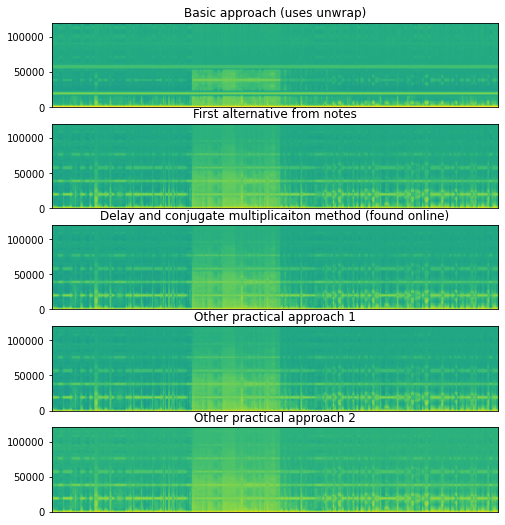

In [10]:
fig, axs = plt.subplots(5, figsize=(8, 9))
for i in range(5):
    m = method[i]
    axs[i].specgram(m, Fs=2.4e5)
    axs[i].set_title(method_name[i])
    axs[i].set_xticks([])

Here are different spectrograms produced by the different methods to demodulate a signal which can be found in the notes or online. Out of all the method, clearly using ``unwrap(diff(angle(signal)))`` appears to work the best.

In [11]:
# demodulating the signal
signal_b_demodulated = np.unwrap(np.diff(np.angle(signal_b_i)))

In [12]:
# designing the filters
butter_16k_b, butter_16k_a = signal.butter(4, [1.6e4], btype='lowpass', fs=240000)

In [13]:
# filtering the signal.
signal_b_filtered = signal.filtfilt(butter_16k_b, butter_16k_a, signal_b_demodulated)

In [14]:
# resampling the signal to 48 kHz
signal_b_resampled = signal_b_filtered[::5]

In [15]:
# Normalizing the signal
signal_b_abs = np.abs(signal_b_resampled)
output_signal = signal_b_abs / np.max(signal_b_abs)
write('output_b_i_20sec.wav', rate=48000, data=output_signal)

## Part (b.ii)

In [16]:
# loading in the floats from the file and building the signal.
floats_b_ii = np.fromfile(file='iq-fm-97M-3.6M.dat', dtype=np.float32)
signal_b_ii = floats_b_ii[::2] + 1.0j * floats_b_ii[1::2]
print(len(signal_b_ii))

12533760


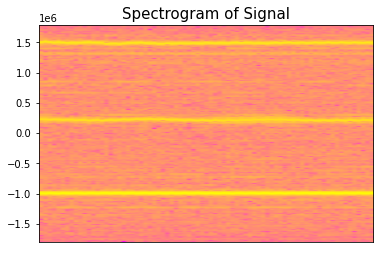

In [17]:
# plotting the signal
plt.specgram(signal_b_ii[:10000], Fs=3.6e6,
            cmap='spring')
plt.xticks([])
plt.title("Spectrogram of Signal", fontsize=15)
plt.show()

In a later point we are asked to estimate the other frequencies also present in this file. We can see that the scale for the signal is 1,000,000 and there are signals at: \
-1.0 MHz (or 96.0 Mhz); \
 0.2 MHz (or 97.2 MHz); and \
 1.5 MHz (or 98.5 MHz);

In [18]:
# recetering the signal by shifting it by 1.0 Mhz
signal_b_recentered = signal_b_ii * np.exp(2j*np.pi*np.arange(len(signal_b_ii))*(1e6/3.6e6))

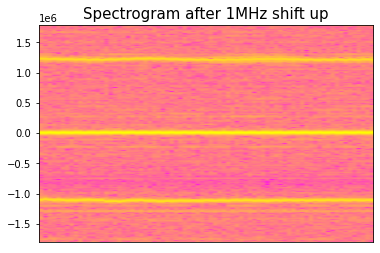

In [19]:
# Plotting the spectrogram of the signal after it has been shifted
plt.specgram(signal_b_recentered[:10000], Fs=3.6e6,
            cmap='spring')
plt.xticks([])
plt.title("Spectrogram after 1MHz shift up", fontsize=15)
plt.show()

In [20]:
# building filters.
butter_200k_b, butter_200k_a = signal.butter(6, [2e5/3.6e6], btype='lowpass')

In [21]:
# filtering the signal
signal_b_filt = signal.filtfilt(butter_200k_b, butter_200k_a, x=signal_b_recentered)

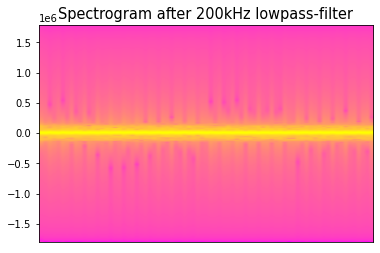

In [22]:
# plotting the filtered signal's spectrogram.
plt.specgram(signal_b_filt[:10000], Fs=3.6e6,
            cmap='spring')
plt.xticks([])
plt.title("Spectrogram after 200kHz lowpass-filter", fontsize=14.5)
plt.show()

In [23]:
fs = 3.6e6
out_fs = 48000

freqs = [-1e6, 2e5, 1.5e6]
print(fs//out_fs)

75.0


In [24]:
# building the vectors to shift the signal.
signal_shifts = [np.exp(
    2j * np.pi * np.arange(len(signal_b_ii)) * (-f/fs)
) for f in freqs]

In [25]:
# shifting the signal so that the respective frequncies are at 0 Hz.
signals_shifted = [
    np.multiply(signal_b_ii, shift) 
    for shift in signal_shifts
]

In [26]:
# building the 200 kHz lowpass filter
butter_200k_b, butter_200k_a = signal.butter(4, [2e5/fs])

# applying filters to each signal.
signals_filtered = [
    signal.filtfilt(butter_200k_b, butter_200k_a, x=sig)
    for sig in signals_shifted
]

In [27]:
# demodulating the signal.
signals_demodulated = [
    np.unwrap(np.diff(np.angle(sig)))
    for sig in signals_filtered
]

In [28]:
# building and applying the lowpass filter
butter_16k_b2, butter_16k_a2 = signal.butter(4, Wn=[1.6e4/fs])

signals_final_filtered = [
    signal.filtfilt(butter_16k_b2, butter_16k_a2, x=sig)
    for sig in signals_demodulated
]

In [29]:
# resampling to 48 kHz (3.6M / 48k = 75)
signals_resampled = [
    sig[::75] 
    for sig in signals_final_filtered
]

In [30]:
# normalizing the values of the signals
signals_normalized = [
    (sig) / np.max(sig)
    for sig in signals_resampled
]

In [31]:
# Writing out to the files.
for i, sig in enumerate(signals_normalized):
    write(f'output_b_{(freqs[i]+97e6)/1e6}_MHz.wav', rate=out_fs, data=sig)